# 2. Geospatial Analytics - Exploration and Model Training

**Mobility and Automotive - Road Safety and Risk Prevention**

## Overview 
Trains two ML models using Spark and AutoML to predict collisions/road safety and to forecast traffic volume.

The first model is a more elaborate one that uses hyperparameter optimization, while the second leverages AutoML for simplicity and time-to-value.

## ML Training and Inference at Scale in Databricks


On the first model, we showcase a real-world model with hyperparameter optimization — all in Spark, without using Pandas. We also demonstrate how to register the model in Unity Catalog (UC) for governance and perform batch inference using the model loaded from UC. Benefits:

- **Performance**: The entire process is built on Spark — not on Pandas, which limits processing to a single node (master). This example already includes hyperparameter optimization using Spark (note: Hyperopt is no longer supported on Databricks).
- **Simplicity**: The model encapsulates complex logic and accepts a dictionary as input for inference.
- **Reusability**: The same transformation logic (dummy creation, handling of null values) is applied both during training and inference.
- **Operationalization**: It’s already integrated with Unity Catalog and MLflow, making it easy to host on Model Serving. Building apps on top of the model is also straightforward.

In this notebook, we use pandas for data exploration, as many data scientists are more familiar with pandas for this task. However, this approach does not leverage all Spark nodes/executors. For training and inference, we utilize the full power of Spark.

Note that Databricks recommends using either Optuna for single-node optimization or Ray Tune for a distributed experience similar to the now-deprecated Hyperopt.

For simplicity, this notebook uses the built-in `TrainValidationSplit` and `ParamGridBuilder` classes from `pyspark.ml.tuning`, allowing cross-validation and hyperparameter optimization directly in Spark.

In [ ]:
%pip install -r requirements.txt
%pip install urllib3==1.26.14 # support method_whitelist
try:
    dbutils.library.restartPython()
except:
    pass



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
%run ./Config

In [3]:
%run ./Utils

In [4]:
spark.sql(f"use catalog {catalog_name}")
spark.sql(f"use schema {schema_name}")
df = spark.sql(f"select * from {catalog_name}.{schema_name}.trip_analyics_synthesis_gold")

## Data Exploration

### Which variables contribute most to accident?



Note: We use pandas in this section as Data Scientists might be familiar with pandas for data exploration. This approach will not leverage all Spark Nodes/executors.

In [38]:
df_pd = df.toPandas()
df_pd.describe()

,trip_trip_id,trip_start_datetime,trip_end_datetime,trip_latitude,trip_longitude,trip_path_order,trip_h3_index,collision_crash_time,collision_latitude,collision_longitude,...,telematics_fcw,telematics_fog_light,telematics_lane_departure,telematics_parking_sensor,telematics_rain_sensor,telematics_rear_view_camera,telematics_seatbelt_off,telematics_tpms,telematics_wiper_blades,vehicle_id
count,1.235852e+06,1235852,1235852,1.235852e+06,1.235852e+06,1.235852e+06,1.235852e+06,32269,32269.000000,32269.000000,...,24730.000000,24730.000000,24730.000000,24730.0,24730.000000,24730.0,24730.000000,24730.000000,24730.000000,1.235852e+06
mean,1.109355e+04,2024-02-01 00:15:29.942925056,2024-02-01 01:02:48.854756864,4.074379e+01,-7.395046e+01,4.530951e+01,6.177331e+17,2024-01-30 08:09:19.227740928,40.741783,-73.950763,...,0.295875,0.007319,0.952527,0.0,0.007319,0.0,0.705338,0.001334,0.007319,5.364826e+09
min,1.000000e+00,2024-01-01 00:04:30,2024-01-01 00:07:42,4.056625e+01,-7.411848e+01,0.000000e+00,6.177331e+17,2024-01-01 00:00:00,40.597446,-74.024430,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00
25%,5.441000e+03,2024-01-16 19:52:41,2024-01-16 20:08:11,4.072612e+01,-7.398657e+01,1.200000e+01,6.177331e+17,2024-01-10 00:00:00,40.724274,-73.984320,...,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,3.089628e+05
50%,1.110300e+04,2024-02-01 09:06:48,2024-02-01 09:18:06,4.075109e+01,-7.397344e+01,2.800000e+01,6.177331e+17,2024-02-04 01:35:00,40.746080,-73.972374,...,0.000000,0.000000,1.000000,0.0,0.000000,0.0,1.000000,0.000000,0.000000,8.589960e+09
75%,1.671300e+04,2024-02-16 16:32:05,2024-02-16 17:04:11,4.076345e+01,-7.394424e+01,6.300000e+01,6.177331e+17,2024-02-15 00:00:00,40.758995,-73.933395,...,1.000000,0.000000,1.000000,0.0,0.000000,0.0,1.000000,0.000000,0.000000,8.590269e+09
max,2.193200e+04,2024-02-29 23:51:20,2024-02-29 23:59:38,4.091203e+01,-7.370362e+01,3.160000e+02,6.177332e+17,2024-02-29 00:00:00,40.869232,-73.707610,...,1.000000,1.000000,1.000000,0.0,1.000000,0.0,1.000000,1.000000,1.000000,1.718000e+10
std,6.462708e+03,NaN,NaN,3.262349e-02,6.023005e-02,4.742370e+01,1.000755e+10,NaN,0.034855,0.049379,...,0.456445,0.085239,0.212652,0.0,0.085239,0.0,0.455900,0.036506,0.085239,5.710100e+09


In [6]:
df_pd.describe(include=[object])

,trip_path_description,collision_crash_date,collision_borough,collision_zip_code,collision_on_street_name,collision_cross_street_name,collision_off_street_name,collision_contributing_factor_vehicle_1,collision_contributing_factor_vehicle_2,collision_contributing_factor_vehicle_3,...,road_description,road_lanes_affected,road_lanes_status,road_navteq_link_id,road_primary_location,road_secondary_location,road_first_article_city,road_second_city,road_event_type,road_event_sub_type
count,1180176,21777,16759,16759,14485,10202,7292,21680,13230,865,...,401753,401753,0,71687,364496,176146,364500,0,401753,401753
unique,3,59,4,111,377,292,297,34,19,3,...,117,1,0,76,107,79,12,0,4,7
top,mid,2024-02-21,MANHATTAN,10002,WEST 59 STREET,5 AVENUE,74 SAINT MARKS PLACE,Unspecified,Unspecified,Unspecified,...,"Due to Construction southbound, SIM25 Bus, SIM...",No Data,NaN,786247045,E 57 St/Madison Av,102 St/157 Av,between New York,NaN,transitMode,construction
freq,597340,2310,11524,1441,1926,789,653,6790,11135,828,...,44640,401753,NaN,9526,89280,41533,158356,NaN,330005,331944


In [64]:
import pandas as pd

class CorrMatrixCalculator:
    def __init__(self,
                 df: pd.DataFrame,
                 numeric_cols: list[str],
                 boolean_cols: list[str],
                 categorical_cols: list[str],
                 target_col: str = "is_collision"):
        self.df = df
        self.numeric_cols = numeric_cols
        self.boolean_cols = boolean_cols
        self.categorical_cols = categorical_cols
        self.target_col = target_col

    def _preprocess(self) -> pd.DataFrame:
        # 1. slice in only the features + the target
        cols = self.numeric_cols + self.boolean_cols + self.categorical_cols + [self.target_col]
        df = self.df[cols].copy()

        # 2. fill numeric missings
        df[self.numeric_cols] = df[self.numeric_cols].fillna(0.0)

        # 3. convert booleans to int (0/1) and fill any missings
        df[self.boolean_cols + [self.target_col]] = (
            df[self.boolean_cols + [self.target_col]]
            .fillna(False)
            .astype(int)
        )

        # 4. one-hot encode only the string categoricals
        df_enc = pd.get_dummies(
            df,
            columns=self.categorical_cols,
            drop_first=False
        )

        return df_enc

    def correlation_with_target(self) -> pd.Series:
        """
        Returns a sorted series of corr(feature, target), descending
        by absolute value.
        """
        df_enc = self._preprocess()
        corr = df_enc.corr()[self.target_col].drop(self.target_col)
        return corr.abs().sort_values(ascending=False)



numeric_cols = [
    "weather_temperature_2m", "weather_precipitation", "weather_rain",
    "weather_snowfall", "weather_snow_depth", "weather_weather_code",
    "weather_wind_speed_10m", "weather_wind_direction_10m",
    "weather_wind_gusts_10m", "traffic_volume", "trip_h3_index"
]

boolean_cols = [
    "telematics_abs", "telematics_accelerometer", "telematics_blind_spot",
    "telematics_brake_pad", "telematics_door_ajar", "telematics_engine_light",
    "telematics_fcw", "telematics_fog_light", "telematics_lane_departure",
    "telematics_parking_sensor", "telematics_rain_sensor",
    "telematics_rear_view_camera", "telematics_seatbelt_off",
    "telematics_tpms", "telematics_wiper_blades"
]

categorical_cols = [
    "road_severity", "road_event_type", "road_event_sub_type"
]

# assume df_pd is your pandas DataFrame
calc = CorrMatrixCalculator(df_pd, numeric_cols, boolean_cols, categorical_cols)
feature_corr = calc.correlation_with_target()

print("Features ranked by |corr| with is_collision:")
display(feature_corr)

Features ranked by |corr| with is_collision:


telematics_accelerometer                                   0.865358
telematics_blind_spot                                      0.856974
telematics_lane_departure                                  0.851318
telematics_seatbelt_off                                    0.730734
telematics_fcw                                             0.471322
telematics_brake_pad                                       0.464306
telematics_abs                                             0.464306
telematics_door_ajar                                       0.463219
traffic_volume                                             0.226118
telematics_fog_light                                       0.073915
telematics_wiper_blades                                    0.073915
telematics_rain_sensor                                     0.073915
road_event_sub_type_construction                           0.040324
road_severity_Unknown                                      0.040094
telematics_engine_light                         

### Insights 💡💡

A correlation coefficient of 0.226 for traffic volume indicates a mild positive linear relationship with collisions. Because it’s only 0.226 (meaning traffic volume alone accounts for just 5 % of the ups and downs in crash), we know most of the story isn’t just “how many cars are on the road.” Traffic volume is one piece of a much bigger puzzle.

In our case, our synthetically generated telematics data act as a proxy for driving behavior and shows a stronger correlation with collisions.

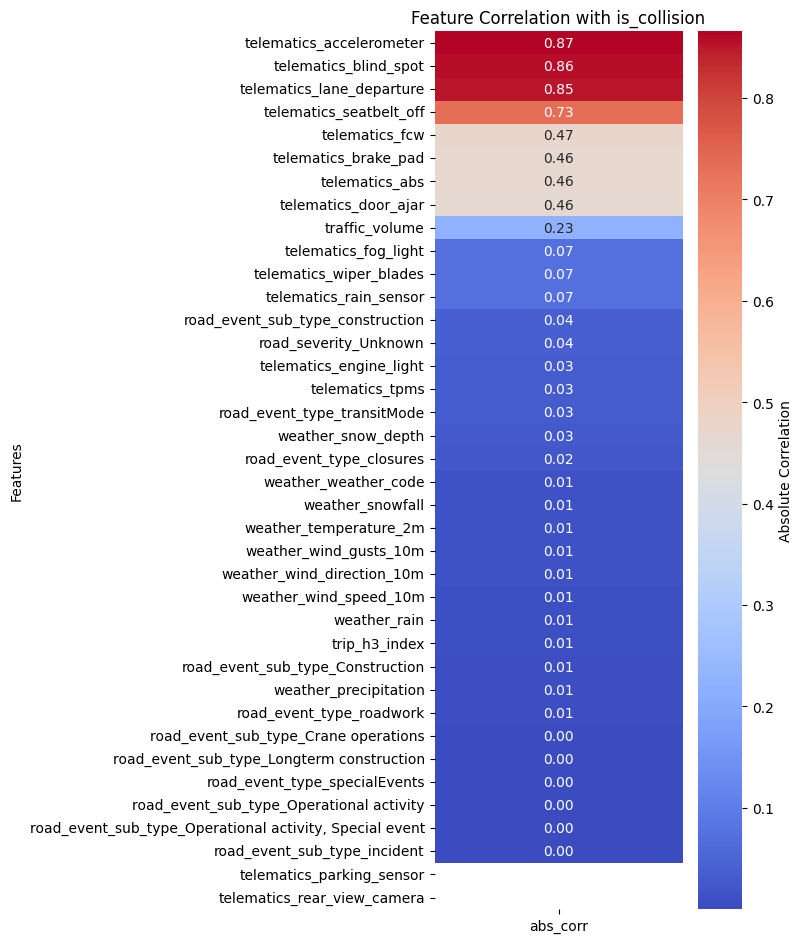

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt


corr_df = feature_corr.to_frame(name="abs_corr")

#Plot with seaborn heatmap
plt.figure(figsize=(4, len(corr_df) * 0.3))
sns.heatmap(
    corr_df,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar_kws={"label": "Absolute Correlation"}
)
plt.xlabel("")           # no x-axis label needed
plt.ylabel("Features")
plt.yticks(rotation=0)    # keep feature names horizontal
plt.title("Feature Correlation with is_collision")

plt.show()

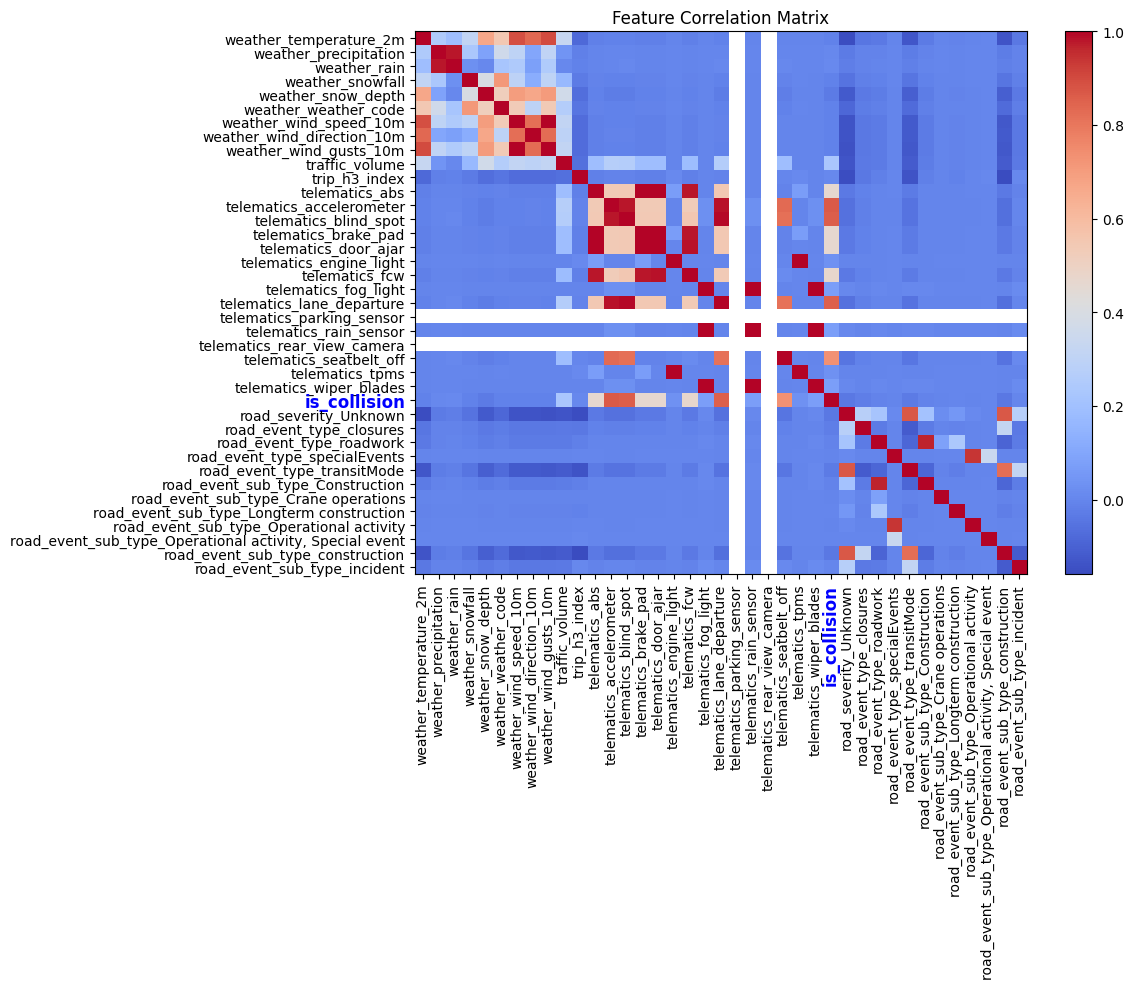

In [63]:
import matplotlib.pyplot as plt


df_enc = calc._preprocess()

corr_matrix = df_enc.corr()
labels = corr_matrix.columns.tolist()
n = len(labels)

# 3. Plot with matplotlib
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(corr_matrix.values, aspect='auto', cmap='coolwarm')
fig.colorbar(im)

# set ticks
ax.set_xticks(range(n))
ax.set_yticks(range(n))
ax.set_xticklabels(labels, rotation=90)
ax.set_yticklabels(labels)

# highlight "is_collision" tick labels in red
for lbl in ax.get_xticklabels() + ax.get_yticklabels():
    if lbl.get_text() == "is_collision":
        lbl.set_color("blue")
        lbl.set_weight("bold")
        lbl.set_size(12)

ax.set_title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

### Traffic Volume Exploration

In [4]:
from keplergl import KeplerGl
from IPython.display import display

df_traffic = spark.read.table(f"{catalog_name}.{schema_name}.traffic_volume_counts_silver")

# Step 2: Aggregate and filter traffic volume
df_dense = (
    df_traffic.groupBy("h3_index", "lat", "long")
    .agg({"vol": "avg"})
    .withColumnRenamed("avg(vol)", "traffic_volume")
    .filter("traffic_volume > 50")  # adjust threshold as needed
)

# Step 3: Add hex string for Kepler
df_hex_vis = df_dense.selectExpr(
    "h3_h3tostring(h3_index) as hex_id",
    "lat", "long", "traffic_volume"
)

# Step 4: Compute center for map
center = df_hex_vis.selectExpr("avg(lat) as lat", "avg(long) as lon").first()
center_lat = center["lat"]
center_lon = center["lon"]

# Step 5: Configure Kepler map centered on your data
map_config = {
    "version": "v1",
    "config": {
        "mapState": {
            "latitude": center_lat,
            "longitude": center_lon,
            "zoom": 10,
            "pitch": 0,
            "bearing": 0
        }
    }
}

# Step 6: Plot the data
map_traffic = KeplerGl(height=600, config=map_config)
map_traffic.add_data(
    data = df_hex_vis.toPandas(),
    name = "Traffic Volume by H3"
)

# Step 7: Display
display(map_traffic)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'mapState': {'latitude': 40.72340788545986, 'longitude': -73.9258…

## Model 1: Predict Collisions




###  Pipeline Model to Handle Training & Inference Input

In [ ]:

from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
numeric_cols = [
    "weather_temperature_2m", "weather_precipitation", "weather_rain",
    "weather_snowfall", "weather_snow_depth", "weather_weather_code",
    "weather_wind_speed_10m", "weather_wind_direction_10m",
    "weather_wind_gusts_10m", "traffic_volume", "trip_h3_index"
]

boolean_cols = [
    "telematics_abs", "telematics_accelerometer", "telematics_blind_spot",
    "telematics_brake_pad", "telematics_door_ajar", "telematics_engine_light",
    "telematics_fcw", "telematics_fog_light", "telematics_lane_departure",
    "telematics_parking_sensor", "telematics_rain_sensor",
    "telematics_rear_view_camera", "telematics_seatbelt_off",
    "telematics_tpms", "telematics_wiper_blades"
]

categorical_cols = [
    "road_severity", "road_event_type", "road_event_sub_type"
]

df = spark.sql(f"select * from {catalog_name}.{schema_name}.`trip_analyics_synthesis_gold`")

##### 
# Select only the columns we care about + target
selected_cols = numeric_cols + boolean_cols + categorical_cols + ["is_collision"]
df_sel = df.select(*selected_cols)

# Fill missing numerics with 0.0
fill_map = { c: 0.0 for c in numeric_cols }
df_sel = df_sel.fillna(fill_map)

# Cast booleans (and your target) to 0/1 ints
for b in boolean_cols + ["is_collision"]:
    df_sel = df_sel.withColumn(b, F.when(F.col(b) == True, 1).otherwise(0))

# Index + one-hot encode your string categoricals
indexers = [
    StringIndexer(inputCol=col, outputCol=col + "_idx", handleInvalid="keep")
    for col in categorical_cols
]
encoders = [
    OneHotEncoder(inputCol=col + "_idx", outputCol=col + "_ohe")
    for col in categorical_cols
]

# Assemble everything into a single features vector
assembler = VectorAssembler(
    inputCols = numeric_cols
              + boolean_cols
              + [c + "_ohe" for c in categorical_cols],
    outputCol = "features"
)

pipeline = Pipeline(stages = indexers + encoders + [assembler])
pipeline_model    = pipeline.fit(df_sel)
train_df = pipeline_model.transform(df_sel).select("features", "is_collision")

input_cols = {
    "numeric": numeric_cols,
    "boolean": boolean_cols,
    "categorical": categorical_cols
}

### Custom Wrapper Model to simplify inference signature

In [ ]:
import mlflow.pyfunc
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, ColSpec, DataType

class CollisionRiskModel(mlflow.pyfunc.PythonModel):
    def __init__(self, input_cols):
        self.input_cols = input_cols  # ensure this is a plain dict

    def load_context(self, context):
        import mlflow.spark
        from pyspark.sql import functions as F
        self.F = F
        self.pipeline_model = mlflow.spark.load_model(context.artifacts["pipeline_model"])
        self.gbt_model = mlflow.spark.load_model(context.artifacts["gbt_model"])

    def predict(self, context, model_input):
        from pyspark.sql import SparkSession
        spark = SparkSession.builder.getOrCreate()

        spark_input = spark.createDataFrame(model_input)
        spark_input = spark_input.fillna({col: 0.0 for col in self.input_cols['numeric']})

        for b in self.input_cols['boolean']:
            spark_input = spark_input.withColumn(b, self.F.when(self.F.col(b) == True, 1).otherwise(0))

        transformed = self.pipeline_model.transform(spark_input)
        result = self.gbt_model.transform(transformed)
        result = result.withColumn("probability", self.F.col("probability").cast("string"))

        return result.select("prediction", "probability").toPandas()
      
    @staticmethod
    def get_signature():
        input_schema = Schema([
            ColSpec(DataType.double, "weather_temperature_2m"),
            ColSpec(DataType.double, "weather_precipitation"),
            ColSpec(DataType.double, "weather_rain"),
            ColSpec(DataType.double, "weather_snowfall"),
            ColSpec(DataType.double, "weather_snow_depth"),
            ColSpec(DataType.double, "weather_weather_code"),
            ColSpec(DataType.double, "weather_wind_speed_10m"),
            ColSpec(DataType.double, "weather_wind_direction_10m"),
            ColSpec(DataType.double, "weather_wind_gusts_10m"),
            ColSpec(DataType.double, "traffic_volume"),
            ColSpec(DataType.long, "trip_h3_index"),
            ColSpec(DataType.integer, "telematics_abs"),
            ColSpec(DataType.integer, "telematics_accelerometer"),
            ColSpec(DataType.integer, "telematics_blind_spot"),
            ColSpec(DataType.integer, "telematics_brake_pad"),
            ColSpec(DataType.integer, "telematics_door_ajar"),
            ColSpec(DataType.integer, "telematics_engine_light"),
            ColSpec(DataType.integer, "telematics_fcw"),
            ColSpec(DataType.integer, "telematics_fog_light"),
            ColSpec(DataType.integer, "telematics_lane_departure"),
            ColSpec(DataType.integer, "telematics_parking_sensor"),
            ColSpec(DataType.integer, "telematics_rain_sensor"),
            ColSpec(DataType.integer, "telematics_rear_view_camera"),
            ColSpec(DataType.integer, "telematics_seatbelt_off"),
            ColSpec(DataType.integer, "telematics_tpms"),
            ColSpec(DataType.integer, "telematics_wiper_blades"),
            ColSpec(DataType.string, "road_severity"),
            ColSpec(DataType.string, "road_event_type"),
            ColSpec(DataType.string, "road_event_sub_type"),
        ])

        output_schema = Schema([
            ColSpec(DataType.double, "prediction"),
            ColSpec(DataType.string, "probability"),  # workaround: serialize probability vector as string
        ])

        return ModelSignature(inputs=input_schema, outputs=output_schema)

    @staticmethod
    def get_sample():
        # Sample input dictionary
        sample_input = {
            "weather_temperature_2m": 22.0,
            "weather_precipitation": 0.0,
            "weather_rain": 0.0,
            "weather_snowfall": 0.0,
            "weather_snow_depth": 0.0,
            "weather_weather_code": 3.0,
            "weather_wind_speed_10m": 5.2,
            "weather_wind_direction_10m": 180.0,
            "weather_wind_gusts_10m": 7.0,
            "traffic_volume": 1200.0,
            "trip_h3_index": 622236172821782527,
            "telematics_abs": 1,
            "telematics_accelerometer": 1,
            "telematics_blind_spot": 0,
            "telematics_brake_pad": 1,
            "telematics_door_ajar": 0,
            "telematics_engine_light": 0,
            "telematics_fcw": 1,
            "telematics_fog_light": 0,
            "telematics_lane_departure": 1,
            "telematics_parking_sensor": 0,
            "telematics_rain_sensor": 0,
            "telematics_rear_view_camera": 1,
            "telematics_seatbelt_off": 0,
            "telematics_tpms": 0,
            "telematics_wiper_blades": 0,
            "road_severity": "Moderate",
            "road_event_type": "Accident",
            "road_event_sub_type": "Rear-End"
        }

        return sample_input



### Train Model and Register in UC

In [ ]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.sql import functions as F

# -----------------------------
# Step 1: Handle class imbalance
# -----------------------------

# Count positives and negatives
pos_count = train_df.filter("is_collision = 1").count()
neg_count = train_df.filter("is_collision = 0").count()

# Compute weights
majority_weight = 1.0
minority_weight = float(neg_count) / float(pos_count)

# Add class_weight column
train_df = train_df.withColumn(
    "class_weight",
    F.when(F.col("is_collision") == 1, minority_weight).otherwise(majority_weight)
)

# Split into training/validation sets
train, val = train_df.randomSplit([0.8, 0.2], seed=42)

# -----------------------------
# Step 2: Train GBT model with tuning
# -----------------------------

gbt = GBTClassifier(
    featuresCol="features",
    labelCol="is_collision",
    weightCol="class_weight"
)

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [3, 5, 7])
             .addGrid(gbt.maxIter, [20, 50, 100])
             .build())

auc_evaluator = BinaryClassificationEvaluator(
    labelCol="is_collision",
    metricName="areaUnderROC"
)

f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="is_collision",
    predictionCol="prediction",
    metricName="f1"
)

tvs = TrainValidationSplit(
    estimator=gbt,
    estimatorParamMaps=paramGrid,
    evaluator=auc_evaluator,
    trainRatio=0.8
)

In [ ]:
# -----------------------------
# Step 3: MLflow training and registration
# -----------------------------

#mlflow.set_registry_uri("databricks-uc")

import mlflow
import mlflow.spark

with mlflow.start_run() as run:
    run_id = run.info.run_id

    # Train model
    model = tvs.fit(train)
    best_model = model.bestModel

    # Evaluate predictions
    predictions = best_model.transform(val)
    predictions = predictions.withColumn("label", F.col("is_collision"))

    # AUC
    auc = auc_evaluator.evaluate(predictions)
    mlflow.log_metric("val_auc", auc)

    # F1 Score using Spark (2 * (precision * recall) / (precision + recall))
    val_predictions = best_model.transform(val)

    f1_score = f1_evaluator.evaluate(val_predictions)

    mlflow.log_metric("val_f1", f1_score)

    artifact_path = "custom_model"

    pipeline_model_path = f"{model_path}/collision_pipeline"
    gbt_model_path = f"{model_path}/collision_gbt"
    
    mlflow.spark.save_model(pipeline_model, pipeline_model_path)
    mlflow.spark.save_model(best_model, gbt_model_path)

    mlflow.pyfunc.log_model(
        artifact_path=artifact_path,
        artifacts={
            "pipeline_model": f"{model_path}/collision_pipeline",
            "gbt_model": f"{model_path}/collision_gbt",
        },
        python_model=CollisionRiskModel(
            input_cols=input_cols
        ),
        input_example=[CollisionRiskModel.get_sample()],
        signature=CollisionRiskModel.get_signature()
    )

    model_uri = f"runs:/{run_id}/{artifact_path}"
    mv = mlflow.register_model(model_uri, model_name)

print(f"✅ AUC: {auc:.4f} | F1: {f1_score:.4f}")
print(f"✅ Model registered as: {model_name}")
print(f"📌 Model URI: {model_uri}")


### Test prediction on the registered model

In [ ]:
import mlflow
import pandas as pd

#model_name = "auto_geospatial.default_v3.collision_prediction"

sample_input = {
    "weather_temperature_2m": 22.0,
    "weather_precipitation": 0.0,
    "weather_rain": 0.0,
    "weather_snowfall": 0.0,
    "weather_snow_depth": 0.0,
    "weather_weather_code": 3.0,
    "weather_wind_speed_10m": 5.2,
    "weather_wind_direction_10m": 180.0,
    "weather_wind_gusts_10m": 7.0,
    "traffic_volume": 1200.0,
    "trip_h3_index": 622236172821782527,
    "telematics_abs": 1,
    "telematics_accelerometer": 1,
    "telematics_blind_spot": 0,
    "telematics_brake_pad": 1,
    "telematics_door_ajar": 0,
    "telematics_engine_light": 0,
    "telematics_fcw": 1,
    "telematics_fog_light": 0,
    "telematics_lane_departure": 1,
    "telematics_parking_sensor": 0,
    "telematics_rain_sensor": 0,
    "telematics_rear_view_camera": 1,
    "telematics_seatbelt_off": 0,
    "telematics_tpms": 0,
    "telematics_wiper_blades": 0,
    "road_severity": "Moderate",
    "road_event_type": "Accident",
    "road_event_sub_type": "Rear-End"
}

# Load the model from UC
loaded_model = mlflow.pyfunc.load_model(model_uri)

# Convert sample input to DataFrame
pd_df = pd.DataFrame([sample_input])
pd_df = pd_df.astype({col: 'int32' for col in pd_df.select_dtypes(include=['int64', 'int']).columns})

predictions = loaded_model.predict(pd_df)

display(predictions)

## Model 2: Forecast Traffic Volume

In this section, we train a basic forecasting model for predicting Traffic Volume using [Databricks AutoML (classic compute)](https://docs.databricks.com/aws/en/machine-learning/automl/forecasting).

The following command starts an AutoML run. You must provide the column that the model should predict in the `target_col` argument and the time column.  
When the run completes, you can follow the link to the best trial notebook to examine the training code.

This example also specifies:
- `horizon=90` to indicate that AutoML should forecast 90 days into the future. 
- `frequency="d"` to specify that a forecast should be provided for each month. 
- `primary_metric="mdape"` to specify the metric to optimize for during training.

### Traing with AutoML

In [ ]:
import databricks.automl
import mlflow.pyfunc
from mlflow.tracking import MlflowClient

import logging
 
# Disable informational messages 
logging.getLogger("py4j").setLevel(logging.WARNING)

# Forecast Traffic Volume with AutoML 
summary = databricks.automl.forecast(
    dataset=df_traffic,
    time_col="timestamp",
    target_col="vol",
    timeout_minutes=60,
    horizon=90, 
    frequency="d"
)



### Get Best Model

In [ ]:
run_id = MlflowClient()

trial_id = summary.best_trial.mlflow_run_id

model_uri = f"runs:/{trial_id}/model"
pyfunc_model = mlflow.pyfunc.load_model(model_uri)


forecasts = pyfunc_model._model_impl.python_model.predict_timeseries()
display(forecasts)

### Plot Forecast with Best Model

In [ ]:

df_true = df_traffic.groupby("timestamp").agg({"vol": "avg"}).toPandas().reset_index()

# Plot the forecasted points
import matplotlib.pyplot as plt

fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
forecasts = pyfunc_model._model_impl.python_model.predict_timeseries(include_history=True)
forecasts = forecasts[(forecasts['ds'].dt.year >= 2024) & (forecasts['ds'].dt.year <= 2025)]
fcst_t = forecasts['ds'].dt.to_pydatetime()
ax.plot(df_true['timestamp'].dt.to_pydatetime(), df_true['avg(vol)'], 'k.', label='Observed data points')
ax.plot(fcst_t, forecasts['yhat'], ls='-', c='#0072B2', label='Forecasts')
ax.fill_between(fcst_t, forecasts['yhat_lower'], forecasts['yhat_upper'],
                color='#0072B2', alpha=0.2, label='Uncertainty interval')
ax.legend()
plt.show()